[目录](./table_of_contents.ipynb)

# 扩展卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

我们发展了线性卡尔曼滤波器的理论。然后，在最后两章，我们提出了使用卡尔曼滤波器的非线性问题的主题。本章我们将学习扩展卡尔曼滤波器(EKF)。EKF通过线性化当前估计点的系统来处理非线性，然后使用线性卡尔曼滤波器对线性化的系统进行滤波。它是用于非线性问题的最早的技术之一，并且仍然是最常用的技术。
 
EKF为滤波器的设计提供了重要的数学挑战;这是书中最具挑战性的一章。我尽我所能地避免使用EKF，而采用其他已经开发出来的用于过滤非线性问题的技术。然而，这个话题是不可避免的;所有经典论文和该领域的大多数当前论文都使用EKF。即使你在自己的工作中没有使用EKF，你也需要熟悉这个主题，以便能够阅读相关文献。

## 线性化卡尔曼滤波器
 
卡尔曼滤波器使用线性方程，所以它对非线性问题不起作用。问题的非线性表现在两方面。首先，流程模型可能是非线性的。物体在大气中下落时遇到阻力，使其加速度减小。阻力系数根据物体的速度而变化。由此产生的行为是非线性的——它不能用线性方程来建模。第二，测量可能是非线性的。例如，雷达给出目标的距离和方位。我们使用非线性的三角函数来计算目标的位置。

对于线性滤波器，我们有这些过程和测量模型的方程:

$$\begin{aligned}\dot{\mathbf x} &= \mathbf{Ax} + w_x\\
\mathbf z &= \mathbf{Hx} + w_z
\end{aligned}$$
 
其中$\mathbf A$为系统动态矩阵。使用在**卡尔曼滤波数学**一章中涉及的状态空间方法，这些方程可以被转换成
$$\begin{aligned}\bar{\mathbf x} &= \mathbf{Fx} \\
\mathbf z &= \mathbf{Hx}
\end{aligned}$$
 
其中$\mathbf F$是基本矩阵。噪声项$w_x$和$w_z$被合并到矩阵$\mathbf R$和$\mathbf Q$中。这种形式的方程允许我们计算步骤$k$的状态给定步骤$k$的测量和步骤$k-1$的状态估计。在前面的章节中，我通过使用牛顿方程描述的问题，建立了你的直觉并最小化了数学。我们知道如何根据高中物理设计$\mathbf F$。
 
对于非线性模型，将线性表达式$\mathbf{Fx} + \mathbf{Bu}$替换为非线性函数$f(\mathbf x， \mathbf u)$，将线性表达式$\mathbf{Hx}$替换为非线性函数$h(\mathbf x)$:

$$\begin{aligned}\dot{\mathbf x} &= f(\mathbf x, \mathbf u) + w_x\\
\mathbf z &= h(\mathbf x) + w_z
\end{aligned}$$
 
你可以想象我们可以通过寻找一组新的卡尔曼滤波方程来最优地解决这些方程。但如果你还记得**非线性滤波**一章中的图表，你就会回想起，将高斯函数传递给非线性函数会导致概率分布不再是高斯分布。所以这行不通。
 
EKF不改变卡尔曼滤波器的线性方程。相反，它将当前估计点的非线性方程*线性化*，并在线性卡尔曼滤波器中使用这种线性化。
 
*线性化*的意思是它听起来像什么。我们找到一条与曲线在某一点上最接近的直线。下图线性化了$x=1.5$时的抛物线$f(x)=x^2-2x$。

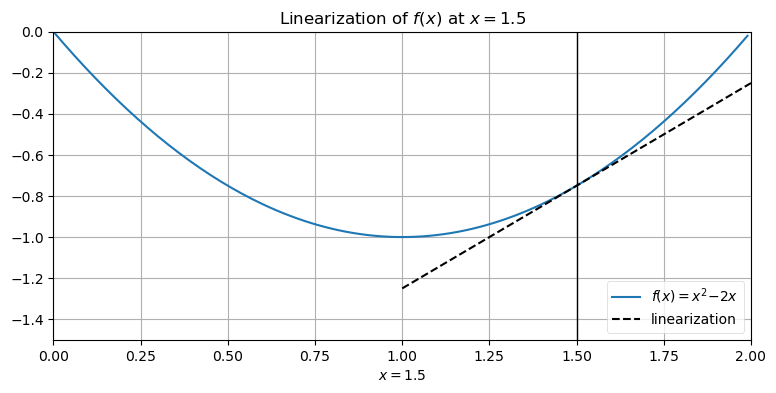

In [3]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_linearization()

如果上面的曲线是过程模型，那么虚线显示了估计$x=1.5$时该曲线的线性化。

我们通过求导来线性化系统，求出曲线的斜率:

$$\begin{aligned}
f(x) &= x^2 -2x \\
\frac{df}{dx} &= 2x - 2
\end{aligned}$$

然后将其计算为$x$:

$$\begin{aligned}m &= f'(x=1.5) \\&= 2(1.5) - 2 \\&= 1\end{aligned}$$ 

微分方程组的线性化也是类似的。我们线性化$f(\mathbf x, \mathbf u)$和$h(\mathbf x)$，方法是对 $\mathbf F$和$\mathbf H$在$\mathbf x_t$和$\mathbf u_t$处求偏导数。我们称矩阵的偏导数为[*雅可比矩阵*](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)。这给了我们离散状态转移矩阵和测量模型矩阵:

$$
\begin{aligned}
\mathbf F 
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

这就引出了下面的EKF方程。我把与线性过滤器的区别放在框框里:
$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

我们通常不使用$\mathbf{Fx}$来传播EKF的状态，因为线性化会导致不准确。通常使用合适的数值积分技术如欧拉或龙格库塔计算$\bar{\mathbf x}$。因此，我写$ mathbf{\bar x} = f(\mathbf x， \mathbf u)$。出于同样的原因，我们在计算残差时不使用$\mathbf{H\bar{x} $，而选择更精确的$ H (\bar{\mathbf x})$。
 
我认为理解EKF最简单的方法是从一个例子开始。稍后你可能会想回来重读这一节。

## 示例:追踪一架飞机
 
这个例子使用地面雷达跟踪一架飞机。我们在上一章为这个问题实现了一个UKF。现在我们将为相同的问题实现一个EKF，这样我们就可以比较滤波器性能和实现滤波器所需的工作水平。
 
雷达的工作原理是发射一束无线电波并扫描回波。光束路径上的任何东西都会将部分信号反射回雷达。通过计时反射信号返回雷达所需的时间，系统可以计算出*倾斜距离*——从雷达装置到物体的直线距离。
 
雷达的倾斜距离$r$、仰角$\epsilon$与飞机的水平位置$x$、高度$y$的关系如下图所示:

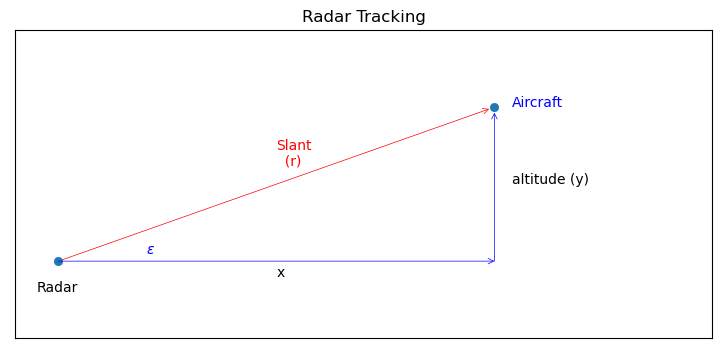

In [4]:
ekf_internal.show_radar_chart()

这就得到了等式:

$$\begin{aligned}
\epsilon &= \tan^{-1} \frac y x\\
r^2 &= x^2 + y^2
\end{aligned}$$ 

### 设计状态变量

我们想要跟踪飞机的位置假设匀速和高度，并测量到飞机的倾斜距离。这意味着我们需要3个状态变量——水平距离、水平速度和高度:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

### 设计过程模型

我们假设这架飞机采用牛顿力学的运动学系统。我们已经在前几章中使用了这个模型，所以通过检查你可能会意识到我们想要

$$\mathbf F = \left[\begin{array}{cc|c} 1 & \Delta t & 0\\
0 & 1 & 0 \\ \hline
0 & 0 & 1\end{array}\right]$$
 
我将矩阵分割成块，以表明左上方块是一个恒定速度模型，对于$x$，右下方块是一个恒定位置模型，对于$y$。
 
但是，让我们练习一下如何找到这些矩阵。我们用一组微分方程来建立系统的模型。我们需要这种形式的方程

$$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{w}$$
where $\mathbf{w}$ is the system noise. 
 
变量$x$和$y$是独立的，所以我们可以分别计算它们。一维运动微分方程为:

$$\begin{aligned}v &= \dot x \\
a &= \ddot{x} = 0\end{aligned}$$
 
现在我们把微分方程化成状态空间形式。如果这是一个二阶或更大阶的微分系统我们必须首先把它们化简成等价的一阶方程组。方程是一阶的，所以我们把它们写成状态空间矩阵的形式

$$\begin{aligned}\begin{bmatrix}\dot x \\ \ddot{x}\end{bmatrix} &= \begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ 
\dot x\end{bmatrix} \\ \dot{\mathbf x} &= \mathbf{Ax}\end{aligned}$$
where $\mathbf A=\begin{bmatrix}0&1\\0&0\end{bmatrix}$. 

回想一下$\mathbf A$是*系统动力学矩阵*。它描述了一组线性微分方程。从它我们必须计算状态转移矩阵$\mathbf F$。$\mathbf F$描述了一个离散时间步长$\Delta t$的计算$\mathbf x$的线性方程组。

计算$\mathbf F$的常用方法是利用矩阵指数的幂级数展开:

$$\mathbf F(\Delta t) = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A \Delta t)^3}{3!} + ... $$
 
$\mathbf A^2 = \begin{bmatrix}0&0\\0&0\end{bmatrix}$，所以$\mathbf A$ 的所有高次幂都是$\mathbf{0}$。因此幂级数展开为:

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf At + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
\mathbf F &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

这和运动学方程的结果是一样的!这个练习是不必要的，除了说明如何从线性微分方程找到状态转移矩阵。我们将以一个需要使用这种技术的示例来结束本章。

### 设计测量模型

测量函数取之前$\bar{\mathbf x}$的状态估计，并将其转换为倾斜距离的测量。我们用勾股定理来推导:

$$h(\bar{\mathbf x}) = \sqrt{x^2 + y^2}$$
 
由于平方根的关系，倾斜距离和地面位置之间的关系是非线性的。我们通过求它在$\mathbf x_t$处的偏导数来线性化它:

$$
\mathbf H = \frac{\partial{h(\bar{\mathbf x})}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}
$$
 
一个矩阵的偏导数叫做雅可比矩阵，它是这样的

$$\frac{\partial \mathbf H}{\partial \bar{\mathbf x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$
 
换句话说，矩阵中的每个元素都是函数$h$对$x$变量的偏导数。解决我们的问题

$$\mathbf H = \begin{bmatrix}{\partial h}/{\partial x} & {\partial h}/{\partial \dot{x}} & {\partial h}/{\partial y}\end{bmatrix}$$

依次解决每个问题:

$$\begin{aligned}
\frac{\partial h}{\partial x} &= \frac{\partial}{\partial x} \sqrt{x^2 + y^2} \\
&= \frac{x}{\sqrt{x^2 + y^2}}
\end{aligned}$$

和

$$\begin{aligned}
\frac{\partial h}{\partial \dot{x}} &=
\frac{\partial}{\partial \dot{x}} \sqrt{x^2 + y^2} \\ 
&= 0
\end{aligned}$$

和

$$\begin{aligned}
\frac{\partial h}{\partial y} &= \frac{\partial}{\partial y} \sqrt{x^2 + y^2} \\ 
&= \frac{y}{\sqrt{x^2 + y^2}}
\end{aligned}$$

推导

$$\mathbf H = 
\begin{bmatrix}
\frac{x}{\sqrt{x^2 + y^2}} & 
0 &
&
\frac{y}{\sqrt{x^2 + y^2}}
\end{bmatrix}$$

这可能看起来令人生畏，所以后退一步，认识到所有这些数学运算都是非常简单的。我们有一个关于飞机倾斜距离的方程，它是非线性的。卡尔曼滤波器只适用于线性方程，所以我们需要找到一个近似$\mathbf H$的线性方程。正如我们上面所讨论的，求非线性方程在某一点的斜率是一个很好的近似。对于卡尔曼滤波器，“给定点”是状态变量$\mathbf x$，因此我们需要对倾斜范围对$\mathbf x$求导。对于线性卡尔曼滤波器，$\mathbf H$是我们在运行滤波器之前计算的常数。对于EKF， $\mathbf H$在每一步都更新，因为计算点$\bar{\mathbf x}$在每个epoch都发生了变化。
 
为了让这个更具体，我们现在写一个Python函数来计算这个问题的雅可比矩阵$h$。

In [5]:
from math import sqrt
def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])

最后，让我们提供$h(\bar{\mathbf x})$的代码:

In [6]:
def hx(x):
    """ compute measurement for slant range that
    would correspond to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

现在让我们为我们的雷达写一个模拟。

In [7]:
from numpy.random import randn
import math

class RadarSim:
    """ Simulates the radar signal returns from an object
    flying at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once 
        for each new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err

### 设计过程和测量噪声
 
雷达测量到目标的距离。我们将使用$\sigma_{range}= 5$ meters来表示噪声。这给了我们

$$\mathbf R = \begin{bmatrix}\sigma_{range}^2\end{bmatrix} = \begin{bmatrix}25\end{bmatrix}$$

$\mathbf Q$的设计需要一些讨论。状态 $\mathbf x= \begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$。前两个元素是位置(向下距离)和速度，所以我们可以使用`Q_discrete_white_noise`噪声来计算$\mathbf Q$的左上角的值。$\mathbf x$的第三个元素是高度，我们假设它与下降距离无关。这将我们引向$\mathbf Q$的块设计:

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & 0 \\ 0 & \mathbf Q_\mathtt{y}\end{bmatrix}$$

### 实现
  
`FilterPy`提供类`ExtendedKalmanFilter`。它的工作原理类似于我们一直使用的`KalmanFilter`类，除了它允许你提供一个函数，计算雅可比矩阵$\mathbf H$和函数$h(\mathbf x)$。
 
我们首先导入过滤器并创建它。`x` 的尺寸是3,`z`的尺寸是1。

```python
from filterpy.kalman import ExtendedKalmanFilter

rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
```
我们创建雷达模拟器:
```python
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
```
我们将在飞机的实际位置附近初始化过滤器:
```python
rk.x = array([radar.pos, radar.vel-10, radar.alt+100])
```

我们使用上面计算的泰勒级数展开的第一项来指定系统矩阵:
```python
dt = 0.05
rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt
```
 
在给$\mathbf R$， $\mathbf Q$和$\mathbf P$赋了合理的值之后，我们可以用一个简单的循环运行过滤器。我们将计算雅可比矩阵$\mathbf H$和$h(x)$的函数传递给 `update`方法。

```python
for i in range(int(20/dt)):
    z = radar.get_range()
    rk.update(array([z]), HJacobian_at, hx)
    rk.predict()
```

添加一些样板代码来保存和绘制我们得到的结果:

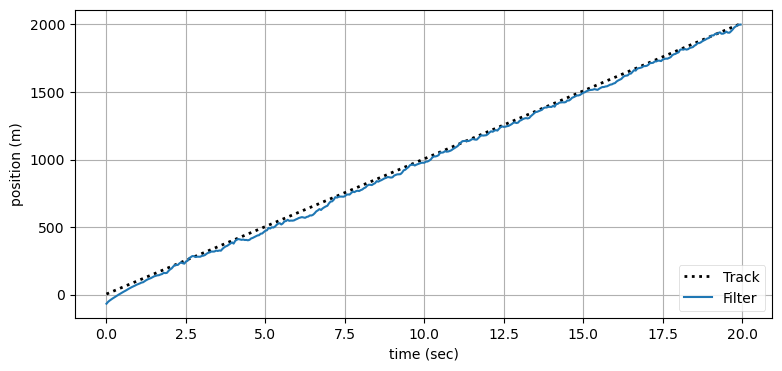

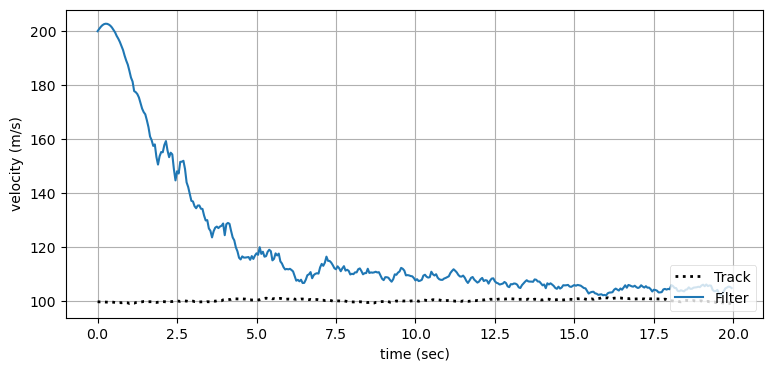

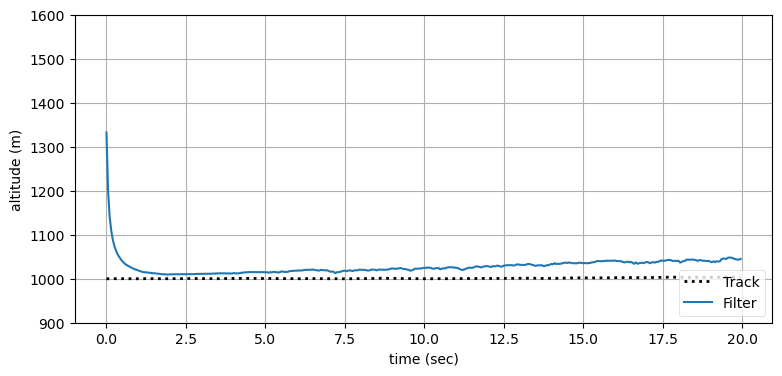

In [8]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray
import numpy as np

dt = 0.05
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)

# make an imperfect starting guess
rk.x = array([radar.pos-100, radar.vel+100, radar.alt+1000])

rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]]) * dt

range_std = 5. # meters
rk.R = np.diag([range_std**2])
rk.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
rk.Q[2,2] = 0.1
rk.P *= 50

xs, track = [], []
for i in range(int(20/dt)):
    z = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    
    rk.update(array([z]), HJacobian_at, hx)
    xs.append(rk.x)
    rk.predict()

xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)
ekf_internal.plot_radar(xs, track, time)

## 使用symy计算雅可比矩阵

根据你对导数的经验你可能会发现雅可比矩阵的计算很困难。即使你发现它很简单，稍微困难一点的问题很容易导致非常困难的计算。

如附录A所述，我们可以使用symy包为我们计算雅可比矩阵。

In [9]:
import sympy
from IPython.display import display
sympy.init_printing(use_latex='mathjax')

x, x_vel, y = sympy.symbols('x, x_vel y')

H = sympy.Matrix([sympy.sqrt(x**2 + y**2)])

state = sympy.Matrix([x, x_vel, y])
J = H.jacobian(state)

display(state)
display(J)

⎡ x  ⎤
⎢    ⎥
⎢xᵥₑₗ⎥
⎢    ⎥
⎣ y  ⎦

⎡     x                y      ⎤
⎢────────────  0  ────────────⎥
⎢   _________        _________⎥
⎢  ╱  2    2        ╱  2    2 ⎥
⎣╲╱  x  + y       ╲╱  x  + y  ⎦

这个结果和我们上面计算的结果是一样的，而且我们的努力要少得多!

## 机器人定位程序
 
是时候试试真正的问题了。我警告你这部分很难。然而，大多数书选择简单的教科书问题和简单的答案，你留下疑惑如何解决一个现实世界的问题。

我们将考虑机器人的定位问题。我们已经在**Unscented卡尔曼滤波器**一章中实现了这一点，如果你还没有读过，我建议你现在就阅读它。在这个场景中，我们有一个机器人，它正在通过一个传感器来检测地标。这可能是一辆使用计算机视觉识别树木、建筑和其他地标的自动驾驶汽车。它可能是那些为你的房子吸尘的小型机器人，或者是仓库里的机器人。

机器人有4个轮子，配置与汽车相同。它通过转动前轮来操纵。这使得机器人在前进时绕后轴旋转。这是我们需要建模的非线性行为。

机器人有一个传感器，可以测量已知目标的距离和方位。这是非线性的，因为从一个范围和方位计算一个位置需要平方根和三角。
 
过程模型和度量模型都是非线性的。EKF可以容纳这两种情况，因此我们暂时认为EKF是解决这一问题的可行选择。

### 机器人运动模型
 
近似地说，汽车是通过向前移动时转动前轮来控制方向的。汽车的前部在以后轮为中心转动时，会朝着车轮指向的方向移动。这种简单的描述由于摩擦引起的滑移、橡胶轮胎在不同速度下的不同行为，以及外胎行驶半径与内胎不同的需求等问题而变得复杂。精确的转向建模需要一套复杂的微分方程。

对于低速机器人应用，一种更简单的“自行车模型”表现良好。这是模型的描述:

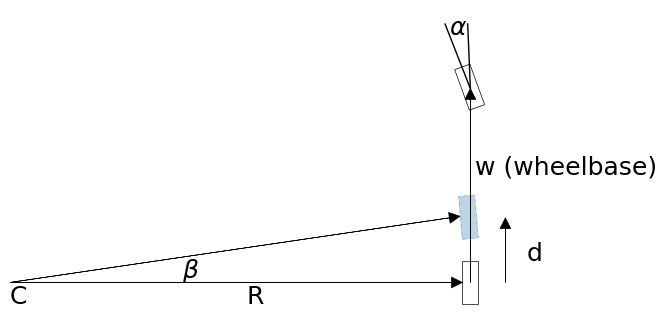

In [10]:
ekf_internal.plot_bicycle()

在**Unscented卡尔曼滤波器**一章中，我们推导了以下方程:

$$\begin{aligned} 
\beta &= \frac d w \tan(\alpha) \\
x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$
 
其中$\theta$是机器人的方向。
 
如果你对转向模型不感兴趣，你不需要了解这个模型的细节。重要的是要认识到我们的运动模型是非线性的，我们需要用卡尔曼滤波器来处理它。

### 设计状态变量
 
对于我们的过滤器，我们将保持机器人的位置$x,y$和方向$\theta$:

$$\mathbf x = \begin{bmatrix}x \\ y \\ \theta\end{bmatrix}$$
 
我们的控制输入$\mathbf u$是速度$v$和转向角度$\alpha$:

$$\mathbf u = \begin{bmatrix}v \\ \alpha\end{bmatrix}$$

### 设计系统模型

我们将系统建模为非线性运动模型加上噪声。

$$\bar x = f(x, u) + \mathcal{N}(0, Q)$$



使用我们上面创建的机器人的运动模型，我们可以将其扩展为

$$\bar{\begin{bmatrix}x\\y\\\theta\end{bmatrix}} = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

我们通过求$f(x,u)$的雅可比矩阵来求$\mathbf F$。

$$\mathbf F = \frac{\partial f(x, u)}{\partial x} =\begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} \\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta}
\end{bmatrix}
$$

当我们计算这些时，我们得到

$$\mathbf F = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

我们可以和symy一起检查一下。

In [11]:
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
sympy.init_printing(use_latex="mathjax", fontsize='16pt')
time = symbols('t')
d = v*time
beta = (d/w)*sympy.tan(alpha)
r = w/sympy.tan(alpha)

fxu = Matrix([[x-r*sympy.sin(theta) + r*sympy.sin(theta+beta)],
              [y+r*sympy.cos(theta)- r*sympy.cos(theta+beta)],
              [theta+beta]])
F = fxu.jacobian(Matrix([x, y, theta]))
F

⎡                        ⎛t⋅v⋅tan(α)    ⎞⎤
⎢                   w⋅cos⎜────────── + θ⎟⎥
⎢        w⋅cos(θ)        ⎝    w         ⎠⎥
⎢1  0  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎢                        ⎛t⋅v⋅tan(α)    ⎞⎥
⎢                   w⋅sin⎜────────── + θ⎟⎥
⎢        w⋅sin(θ)        ⎝    w         ⎠⎥
⎢0  1  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎣0  0                  1                 ⎦

这看起来有点复杂。我们可以使用symy来替换术语:

In [12]:
# reduce common expressions
B, R = symbols('beta, R')
F = F.subs((d/w)*sympy.tan(alpha), B)
F.subs(w/sympy.tan(alpha), R)

⎡1  0  -R⋅cos(θ) + R⋅cos(β + θ)⎤
⎢                              ⎥
⎢0  1  -R⋅sin(θ) + R⋅sin(β + θ)⎥
⎢                              ⎥
⎣0  0             1            ⎦

这种形式验证了雅可比矩阵的计算是正确的。

现在我们可以把注意力转移到噪音上。在这里，噪声是在我们的控制输入，所以它是在*控制空间*。换句话说，我们命令一个特定的速度和转向角度，但我们需要将其转换为误差$x, y， \theta$。在真实的系统中，这可能会随着速度而变化，因此需要为每一个预测重新计算。我将选择这个作为噪声模型;对于一个真正的机器人，你需要选择一个能准确描述系统错误的模型。

$$\mathbf{M} = \begin{bmatrix}\sigma_{vel}^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}$$
 
如果这是一个线性问题，我们将使用现在熟悉的$\mathbf{FMF}^\mathsf T$形式从控制空间转换到状态空间。由于我们的运动模型是非线性的，我们不试图找到一个封闭形式的解，而是用雅可比矩阵线性化它，我们将其命名为$\mathbf{V}$。

$$\mathbf{V} = \frac{\partial f(x, u)}{\partial u} \begin{bmatrix}
\frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \alpha} \\
\frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \alpha} \\
\frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \alpha}
\end{bmatrix}$$

这些偏导数变得非常难处理。让我们用symy来计算。

In [13]:
V = fxu.jacobian(Matrix([v, alpha]))
V = V.subs(sympy.tan(alpha)/w, 1/R) 
V = V.subs(time*v/R, B)
V = V.subs(time*v, 'd')
V

⎡                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅cos(β + θ)   w⋅⎝- tan (α) - 1⎠⋅sin(θ)   w⋅⎝- ta
⎢t⋅cos(β + θ)  ────────────────────────── - ──────────────────────── + ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅sin(β + θ)   w⋅⎝- tan (α) - 1⎠⋅cos(θ)   w⋅⎝- ta
⎢t⋅sin(β + θ)  ────────────────────────── + ──────────────────────── - ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                                                  ⎛

这将使您了解到EKF在数学上变得多么棘手。

这给了我们预测方程的最终形式:

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf x + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}\\
\mathbf{\bar P} &=\mathbf{FPF}^{\mathsf T} + \mathbf{VMV}^{\mathsf T}
\end{aligned}$$

这种形式的线性化并不是预测$\mathbf x$的唯一方法。例如，我们可以使用一种数值积分技术，如*龙格库塔*来计算机器人的运动。如果时间步长比较大，就需要这样做。EKF不像卡尔曼滤波器那样是固定不变的。对于一个真正的问题，你必须小心地用微分方程建模你的系统，然后确定最合适的方法来解决这个系统。正确的方法取决于您所需的精度、方程的非线性程度、处理器预算和数值稳定性问题。

### 设计测量模型

机器人的传感器提供了对景观中多个已知位置的噪声轴承和距离测量。测量模型必须将状态$\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf T$转换为一个距离和地标的方位。如果$\mathbf p$是一个地标的位置，则范围$r$是

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

传感器提供了相对于机器人方向的轴承，所以我们必须从轴承中减去机器人的方向来获得传感器读数，如下所示:

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$


因此我们的度量模型$h$为


$$\begin{aligned}
\mathbf z& = h(\bar{\mathbf x}, \mathbf p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

这显然是非线性的，所以我们需要线性化$h$在$\mathbf x$处，通过取它的雅可比矩阵。我们用下面的symy来计算。

In [13]:
px, py = symbols('p_x, p_y')
z = Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(Matrix([x, y, theta]))

⎡          -pₓ + x                      -p_y + y             ⎤
⎢───────────────────────────  ───────────────────────────  0 ⎥
⎢   ________________________     ________________________    ⎥
⎢  ╱         2            2     ╱         2            2     ⎥
⎢╲╱  (pₓ - x)  + (p_y - y)    ╲╱  (pₓ - x)  + (p_y - y)      ⎥
⎢                                                            ⎥
⎢       -(-p_y + y)                   -(pₓ - x)              ⎥
⎢  ──────────────────────       ──────────────────────     -1⎥
⎢          2            2               2            2       ⎥
⎣  (pₓ - x)  + (p_y - y)        (pₓ - x)  + (p_y - y)        ⎦

现在我们需要把它写成一个Python函数。例如，我们可以这样写:

In [14]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

我们还需要定义一个将系统状态转换为度量值的函数。

In [15]:
from math import atan2

def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

### 设计测量噪声

因此，可以合理地假设距离和方位测量的噪声是独立的

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### 实现

我们将使用`FilterPy`的`ExtendedKalmanFilter`类来实现过滤器。它的`predict()`方法使用流程模型的标准线性方程。我们的是非线性的，所以我们必须用自己的实现覆盖`predict()`。我还想用这个类来模拟机器人，所以我将添加一个方法`move()`来计算机器人的位置，`predict()`和我的模拟都可以调用这个方法。

预测步骤的矩阵是相当大的。在编写这段代码时，我犯了几个错误，直到我最终使它工作。我是通过使用symy的`evalf`函数才发现错误的。`evalf`使用变量的特定值计算symy `Matrix`。我决定向您演示这一技术，并在卡尔曼滤波代码中使用了`evalf`。你需要理解以下几点。
 
首先，`evalf`使用字典来指定值。例如，如果你的矩阵包含`x`和`y`，你可以写

```python
    M.evalf(subs={x:3, y:17})
```
 
求`x=3`和`y=17`的矩阵值。
 
其次，`evalf`返回`sympy.Matrix` 矩阵的对象。使用 `numpy.array(M).astype(float)` 将其转换为NumPy数组。`numpy.array(M)`创建一个类型为`object`的数组，这不是你想要的。

这里是EKF的代码:

In [16]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel*u[0]**2, 0], 
                   [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

现在我们有另一个问题要处理。理论上剩余的值被计算为$y = z - h(x)$，但这是行不通的，因为我们的测量包含了一个角。假设z的方位是$1^\circ$，而$h(x)$的方位是$359^\circ$。简单地减去它们将得到角差$-358^\circ$，而正确的值是$2^\circ$。我们必须编写代码来正确计算位置残差。

In [17]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

其余代码运行模拟并绘制结果，到目前为止不需要太多注释。我创建了一个变量`landmarks`，它包含地标坐标。我每秒更新模拟机器人的位置10次，但每秒只运行一次EKF。这有两个原因。首先，我们没有使用龙格-库塔来整合运动微分方程，所以较窄的时间步长可以让我们的模拟更精确。其次，在嵌入式系统中，有限的处理速度是相当正常的。这迫使您只在绝对需要的时候频繁地运行卡尔曼滤波器。

In [18]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
                  [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([1.1, .01]) 

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

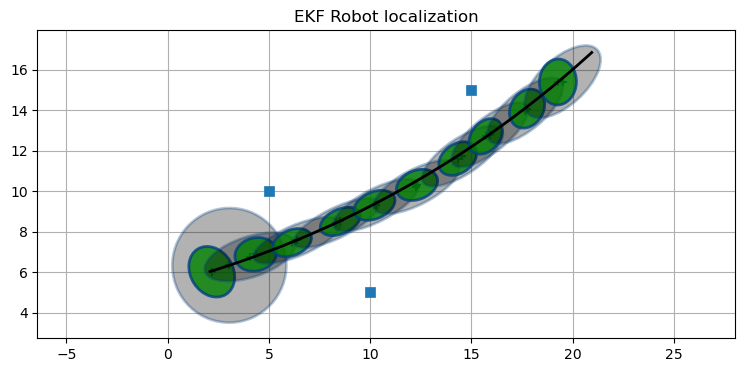

Final P: [0.024 0.041 0.002]


In [19]:
landmarks = array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

我把这些地标画成立体的正方形。机器人的路径用黑线画出来。预测步长的协方差椭圆为浅灰色，更新的协方差为绿色。为了使它们在这个比例下可见，我将椭圆边界设置为6$\sigma$。
 
我们可以看到，我们的运动模型增加了很多不确定性，而且大多数误差都在运动方向上。我们从蓝色椭圆的形状来确定。经过几个步骤，我们可以看到滤波器包含地标测量和误差改善。
 
我在UKF章节中使用了相同的初始条件和地标位置。UKF在误差椭圆方面取得了更好的精度。这两种方法的表现都和它们对$\mathbf x$的估计差不多。
 
现在让我们添加另一个地标。

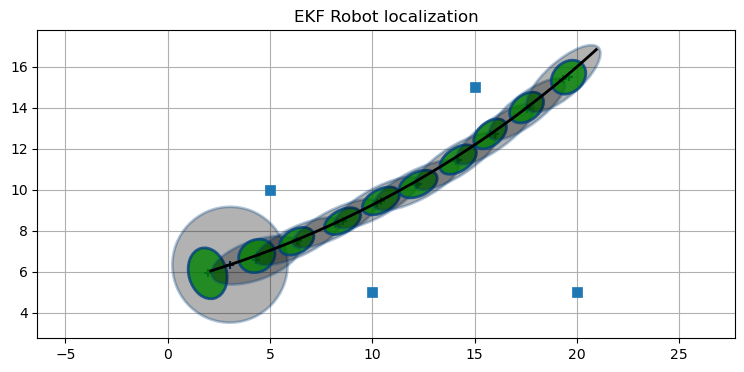

Final P: [0.021 0.02  0.002]


In [20]:
landmarks = array([[5, 10], [10, 5], [15, 15], [20, 5]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
plt.show()
print('Final P:', ekf.P.diagonal())

在接近轨道末端的估计中，不确定性较小。我们可以通过使用前两个路标看到多个路标对不确定性的影响。

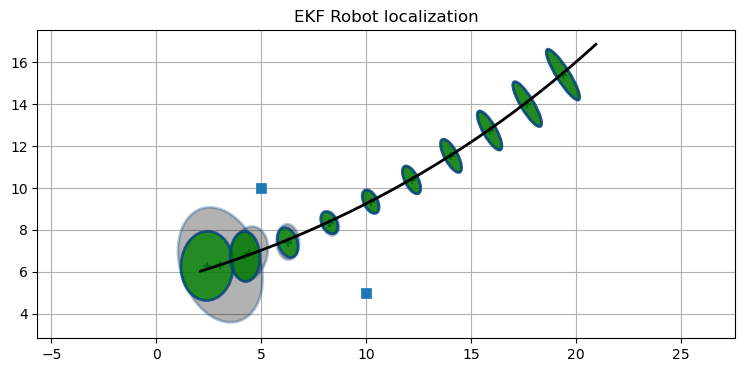

Final P: [0.02  0.045 0.   ]


In [21]:
ekf = run_localization(
    landmarks[0:2], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

经过地标后，估计值很快就偏离了机器人的路径。协方差也快速增长。让我们看看只有一个里程碑会发生什么:

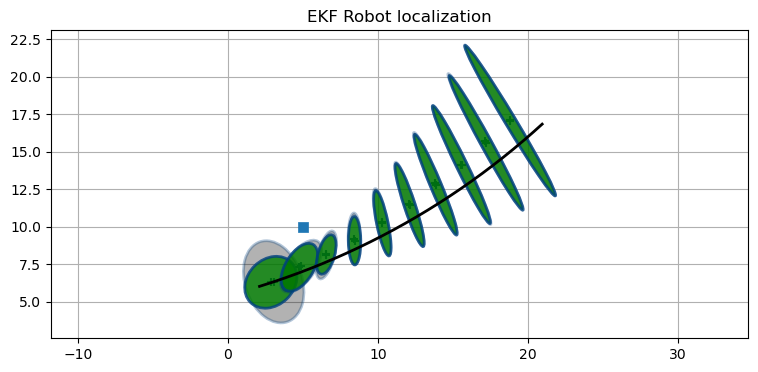

Final P: [0.304 0.771 0.004]


In [22]:
ekf = run_localization(
    landmarks[0:1], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

正如你可能怀疑的那样，一个里程碑会产生一个非常糟糕的结果。相反，大量的地标让我们能够做出非常准确的估计。

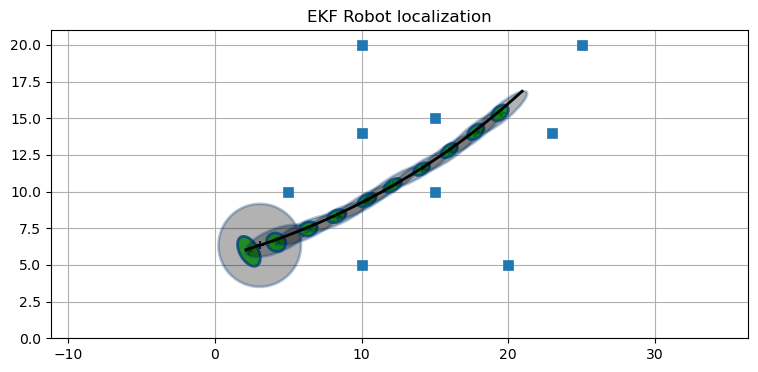

Final P: [0.009 0.008 0.001]


In [23]:
landmarks = array([[5, 10], [10,  5], [15, 15], [20,  5], [15, 10], 
                   [10,14], [23, 14], [25, 20], [10, 20]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1, ylim=(0, 21))
print('Final P:', ekf.P.diagonal())

### 讨论
 
我说这是一个真实的问题，在某种程度上确实是。我看过一些替代的演示用机器人运动模型得出了更简单的雅可比矩阵。另一方面，我的运动模型在许多方面也很简单。首先，它使用了自行车模型。一辆真正的汽车有两组轮胎，每组轮胎的行驶半径不同。轮子不能很好地抓住地面。我还假设机器人对控制输入立即做出反应。Sebastian Thrun在《概率机器人》中写道，这种简化模型是合理的，因为用于跟踪真实车辆时，过滤器表现良好。这里的教训是，虽然你必须有一个合理准确的非线性模型，但它不需要完美地运行良好。作为设计师，你需要平衡模型的保真度、数学难度和执行线性代数所需的CPU时间。
 
这个问题的另一种简化方式是我们假设我们知道地标和测量值之间的对应关系。但假设我们使用雷达，我们如何知道特定的信号返回对应于当地场景中的特定建筑?这个问题暗示了SLAM算法——同时定位和绘图。SLAM不是本书的重点，所以我不会详细阐述这个主题。

## UKF vs EKF

  
在上一章中，我使用UKF来解决这个问题。执行方面的差异应该非常清楚。尽管是一个基本的运动模型，但状态和测量模型的雅可比矩阵的计算并不简单。另一个问题可能会导致难于或不可能通过解析推导的雅可比矩阵。相反，UKF只需要您提供一个计算系统运动模型的函数和另一个用于测量模型的函数。
 
在很多情况下，雅可比矩阵不能通过解析找到。细节超出了这本书的范围，但是你必须使用数值方法来计算雅可比矩阵。这项任务不是微不足道的，你将花费大量的硕士学位在STEM学校学习处理这种情况的技术。即使这样，你可能也只能解决与你的领域相关的问题——航空工程师对Navier Stokes方程了解很多，但对化学反应速率建模了解不多。
 
所以，ukf很简单。他们是准确的吗?在实践中，他们往往比EKF表现得更好。你可以找到大量的研究论文，证明UKF在不同的问题领域优于EKF。不难理解为什么这是真的。EKF通过在单个点上线性化系统模型和测量模型来工作，UKF使用$2n+1$点。
 
让我们看一个具体的例子。取$f(x) = x^3$并通过它传递一个高斯分布。我将用蒙特卡罗模拟计算出一个准确的答案。我根据高斯分布随机生成50,000个点，将每个点传递到$f(x)$，然后计算结果的均值和方差。

EKF将函数线性化，通过求导求出在估值点$x$处的斜率。这个斜率变成了我们用来变换高斯函数的线性函数。这是一个情节。

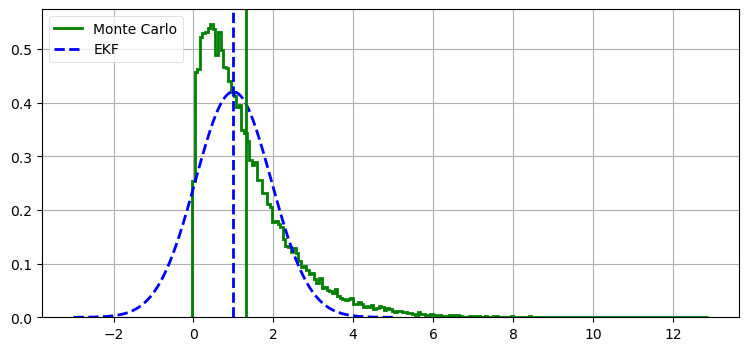

actual mean=1.30, std=1.13
EKF    mean=1.00, std=0.95


In [24]:
import kf_book.nonlinear_plots as nonlinear_plots
nonlinear_plots.plot_ekf_vs_mc()

EKF计算相当不准确。相比之下，UKF的性能如下:

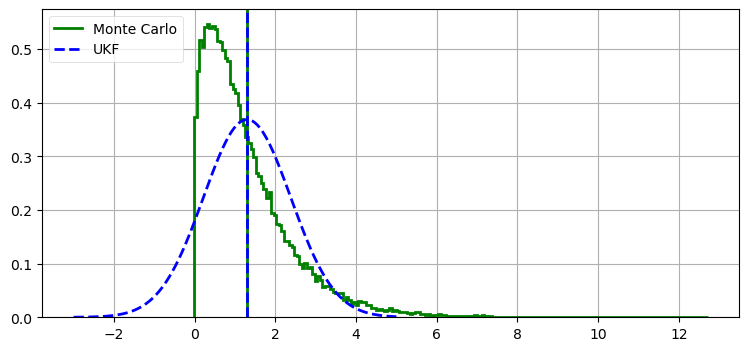

actual mean=1.29, std=1.12
UKF    mean=1.30, std=1.08


In [25]:
nonlinear_plots.plot_ukf_vs_mc(alpha=0.001, beta=3., kappa=1.)

这里我们可以看到UKF的计算精确到小数点后2位。标准差略有偏差，但您也可以通过使用$\alpha$、$\beta$和$\gamma$参数来微调UKF计算分布的方式，以生成sigma点。这里我使用$\alpha=0.001$， $\beta=3$， $\gamma=1$。您可以随意修改它们以查看结果。你应该能得到比我更好的结果。但是，要避免针对特定测试过度调优UKF。对于您的测试用例，它可能表现得更好，但一般来说更差。